In [2]:
# Power Meter Data - Analysis - Raw Goods Cooler System
# Analysis of power data from two units of raw goods cooler system
# Data collected from current transformer (CT) data loggers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import find_peaks
from sklearn.cluster import KMeans

In [3]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Power Meter Analysis - Cold Storage Refrigeration System")
print("=======================================================")
print("Equipment: CU-3")
print("System Type: Cold Storage Refrigeration with Electric Defrost")
print("Analysis Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print()


Power Meter Analysis - Cold Storage Refrigeration System
Equipment: CU-3
System Type: Cold Storage Refrigeration with Electric Defrost
Analysis Date: 2025-08-25 13:56:50



In [4]:
## 1. DATA LOADING AND CLEANING

def load_power_data(filename):
    """Load power meter data from CSV file"""
    try:
        df = pd.read_csv(filename)
        print(f"Raw data loaded: {len(df)} records")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def clean_power_data(df):
    """Clean and prepare power meter data for analysis"""
    df_clean = df.copy()
    
    # Convert time column to datetime
    df_clean['time'] = pd.to_datetime(df_clean['time'])
    
    # Ensure numeric columns are properly typed
    numeric_columns = ['raw_mamp', 'ampere', 'volt', 'power_factor', 'power_total']
    for col in numeric_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Remove any rows with missing critical data
    df_clean = df_clean.dropna(subset=['time', 'power_total'])
    
    # Sort by time
    df_clean = df_clean.sort_values('time').reset_index(drop=True)
    
    # Calculate time differences for interval analysis
    df_clean['time_diff'] = df_clean['time'].diff().dt.total_seconds() / 60  # minutes
    
    # Calculate power metrics
    df_clean['apparent_power'] = df_clean['ampere'] * df_clean['volt'] / 1000  # kVA
    df_clean['reactive_power'] = np.sqrt(np.maximum(0, df_clean['apparent_power']**2 - df_clean['power_total']**2))  # kVAR
    
    print(f"\nCleaned data: {len(df_clean)} valid records")
    print(f"Time range: {df_clean['time'].min()} to {df_clean['time'].max()}")
    print(f"Monitoring period: {(df_clean['time'].max() - df_clean['time'].min()).days:.1f} days")
    print(f"Average sampling interval: {df_clean['time_diff'].median():.1f} minutes")
    print(f"Power range: {df_clean['power_total'].min():.2f} to {df_clean['power_total'].max():.2f} kW")
    
    return df_clean

# Load and clean the data
print("Loading power meter data...")
df_raw = load_power_data('output/cleaned_Yogurt_Filler.csv')

if df_raw is not None:
    df = clean_power_data(df_raw)
    print(f"\nEquipment ID: {df['equipment_id'].iloc[0]}")
else:
    print("Failed to load data")
    df = None


Loading power meter data...
Raw data loaded: 1615 records
Columns: ['time', 'raw_mamp', 'ampere', 'volt', 'power_factor', 'power_total', 'equipment_id']

Cleaned data: 1615 valid records
Time range: 2025-08-15 00:01:00 to 2025-08-21 09:08:00
Monitoring period: 6.0 days
Average sampling interval: 6.0 minutes
Power range: 0.10 to 20.20 kW

Equipment ID: Yogurt Filler


In [5]:
## 2. POWER CONSUMPTION METRICS ANALYSIS

def calculate_power_metrics(df):
    """Calculate comprehensive power consumption metrics"""
    
    metrics = {}
    
    # Basic power statistics
    metrics['total_records'] = len(df)
    metrics['monitoring_hours'] = (df['time'].max() - df['time'].min()).total_seconds() / 3600
    metrics['average_interval_min'] = df['time_diff'].median()
    
    # Power consumption statistics
    metrics['mean_power_kw'] = df['power_total'].mean()
    metrics['max_power_kw'] = df['power_total'].max()
    metrics['min_power_kw'] = df['power_total'].min()
    metrics['std_power_kw'] = df['power_total'].std()
    
    # Energy calculations
    # Approximate energy using trapezoidal integration
    time_hours = df['time_diff'].fillna(df['time_diff'].median()) / 60  # convert to hours
    metrics['total_energy_kwh'] = (df['power_total'] * time_hours).sum()
    metrics['average_hourly_consumption'] = metrics['total_energy_kwh'] / metrics['monitoring_hours']
    
    # Electrical parameters
    metrics['average_voltage'] = df['volt'].mean()
    metrics['average_current'] = df['ampere'].mean()
    metrics['average_power_factor'] = df['power_factor'].mean()
    metrics['max_current'] = df['ampere'].max()
    
    # Load factor analysis
    metrics['load_factor'] = metrics['mean_power_kw'] / metrics['max_power_kw']
    
    # Power demand analysis
    metrics['peak_demand_kw'] = df['power_total'].quantile(0.95)  # 95th percentile
    metrics['base_load_kw'] = df['power_total'].quantile(0.05)   # 5th percentile
    
    return metrics

# Calculate power metrics
print("\n" + "="*60)
print("POWER CONSUMPTION METRICS")
print("="*60)

if df is not None:
    metrics = calculate_power_metrics(df)
    
    print(f"Equipment: {df['equipment_id'].iloc[0]}")
    print(f"Monitoring Period: {metrics['monitoring_hours']:.1f} hours ({metrics['monitoring_hours']/24:.1f} days)")
    print(f"Data Points: {metrics['total_records']:,}")
    print(f"Sampling Interval: {metrics['average_interval_min']:.1f} minutes")
    print()
    print("POWER STATISTICS:")
    print(f"  Mean Power: {metrics['mean_power_kw']:.2f} kW")
    print(f"  Peak Power: {metrics['max_power_kw']:.2f} kW")
    print(f"  Base Load: {metrics['base_load_kw']:.2f} kW")
    print(f"  Standard Deviation: {metrics['std_power_kw']:.2f} kW")
    print(f"  Load Factor: {metrics['load_factor']:.2f}")
    print()
    print("ENERGY CONSUMPTION:")
    print(f"  Total Energy: {metrics['total_energy_kwh']:.1f} kWh")
    print(f"  Average Hourly: {metrics['average_hourly_consumption']:.2f} kW")
    print(f"  Daily Average: {metrics['average_hourly_consumption']*24:.1f} kWh/day")
    print()
    print("ELECTRICAL PARAMETERS:")
    print(f"  Average Voltage: {metrics['average_voltage']:.0f} V")
    print(f"  Average Current: {metrics['average_current']:.1f} A")
    print(f"  Peak Current: {metrics['max_current']:.1f} A")
    print(f"  Power Factor: {metrics['average_power_factor']:.2f}")



POWER CONSUMPTION METRICS
Equipment: Yogurt Filler
Monitoring Period: 153.1 hours (6.4 days)
Data Points: 1,615
Sampling Interval: 6.0 minutes

POWER STATISTICS:
  Mean Power: 2.98 kW
  Peak Power: 20.20 kW
  Base Load: 0.10 kW
  Standard Deviation: 3.55 kW
  Load Factor: 0.15

ENERGY CONSUMPTION:
  Total Energy: 455.0 kWh
  Average Hourly: 2.97 kW
  Daily Average: 71.3 kWh/day

ELECTRICAL PARAMETERS:
  Average Voltage: 476 V
  Average Current: 4.5 A
  Peak Current: 30.6 A
  Power Factor: 0.80


In [6]:
## 3. ELECTRIC DEFROST CYCLE ANALYSIS

def analyze_defrost_cycles(df, defrost_threshold=15.0, min_duration=10, min_gap=30):
    """
    Analyze electric defrost cycles in cold storage system
    
    Parameters:
    - defrost_threshold: Power level (kW) above which defrost is likely occurring
    - min_duration: Minimum duration (minutes) for a valid defrost cycle
    - min_gap: Minimum gap (minutes) between defrost cycles
    """
    
    # Identify potential defrost periods (high power consumption)
    df['is_defrost'] = df['power_total'] >= defrost_threshold
    
    # Find defrost cycle start and end times
    df['defrost_change'] = df['is_defrost'].diff()
    defrost_starts = df[df['defrost_change'] == 1].copy()
    defrost_ends = df[df['defrost_change'] == -1].copy()
    
    # Match starts with ends to create complete cycles
    defrost_cycles = []
    
    for _, start_row in defrost_starts.iterrows():
        # Find the next end after this start
        next_ends = defrost_ends[defrost_ends['time'] > start_row['time']]
        if not next_ends.empty:
            end_row = next_ends.iloc[0]
            
            # Calculate cycle duration
            duration = (end_row['time'] - start_row['time']).total_seconds() / 60  # minutes
            
            if duration >= min_duration:  # Only include cycles meeting minimum duration
                cycle_data = df[(df['time'] >= start_row['time']) & (df['time'] <= end_row['time'])]
                
                defrost_cycles.append({
                    'start_time': start_row['time'],
                    'end_time': end_row['time'],
                    'duration_min': duration,
                    'peak_power_kw': cycle_data['power_total'].max(),
                    'avg_power_kw': cycle_data['power_total'].mean(),
                    'energy_kwh': (cycle_data['power_total'] * cycle_data['time_diff'].fillna(5) / 60).sum()
                })
    
    defrost_df = pd.DataFrame(defrost_cycles)
    
    if not defrost_df.empty:
        # Calculate time between defrost cycles
        defrost_df['time_since_last'] = defrost_df['start_time'].diff().dt.total_seconds() / 3600  # hours
        
        # Add day/hour analysis
        defrost_df['hour_of_day'] = defrost_df['start_time'].dt.hour
        defrost_df['day_of_week'] = defrost_df['start_time'].dt.day_name()
        defrost_df['date'] = defrost_df['start_time'].dt.date
    
    return defrost_df, df

def calculate_defrost_metrics(defrost_df, total_hours):
    """Calculate defrost cycle performance metrics"""
    
    if defrost_df.empty:
        return {"message": "No defrost cycles detected"}
    
    metrics = {}
    
    # Cycle frequency and timing
    metrics['total_cycles'] = len(defrost_df)
    metrics['cycles_per_day'] = len(defrost_df) / (total_hours / 24)
    metrics['avg_cycle_duration'] = defrost_df['duration_min'].mean()
    metrics['avg_time_between_cycles'] = defrost_df['time_since_last'].mean()
    
    # Power and energy
    metrics['avg_defrost_power'] = defrost_df['avg_power_kw'].mean()
    metrics['peak_defrost_power'] = defrost_df['peak_power_kw'].max()
    metrics['total_defrost_energy'] = defrost_df['energy_kwh'].sum()
    metrics['percent_energy_defrost'] = (metrics['total_defrost_energy'] / 
                                        (defrost_df['energy_kwh'].sum() + 1)) * 100  # Avoid division by zero
    
    # Timing patterns
    metrics['most_common_hour'] = defrost_df['hour_of_day'].mode().iloc[0] if not defrost_df['hour_of_day'].mode().empty else None
    metrics['hour_distribution'] = defrost_df['hour_of_day'].value_counts().sort_index()
    
    return metrics

# Analyze defrost cycles
print("\n" + "="*60)
print("ELECTRIC DEFROST CYCLE ANALYSIS")
print("="*60)

if df is not None:
    # Analyze defrost patterns
    defrost_df, df_with_defrost = analyze_defrost_cycles(df, defrost_threshold=15.0)
    
    if not defrost_df.empty:
        defrost_metrics = calculate_defrost_metrics(defrost_df, metrics['monitoring_hours'])
        
        print(f"Defrost Threshold: 15.0 kW")
        print(f"Total Defrost Cycles: {defrost_metrics['total_cycles']}")
        print(f"Cycles per Day: {defrost_metrics['cycles_per_day']:.1f}")
        print(f"Average Cycle Duration: {defrost_metrics['avg_cycle_duration']:.1f} minutes")
        print(f"Average Time Between Cycles: {defrost_metrics['avg_time_between_cycles']:.1f} hours")
        print()
        print("DEFROST POWER CONSUMPTION:")
        print(f"  Average Defrost Power: {defrost_metrics['avg_defrost_power']:.1f} kW")
        print(f"  Peak Defrost Power: {defrost_metrics['peak_defrost_power']:.1f} kW")
        print(f"  Total Defrost Energy: {defrost_metrics['total_defrost_energy']:.1f} kWh")
        print()
        print("DEFROST TIMING PATTERNS:")
        print(f"  Most Common Hour: {defrost_metrics['most_common_hour']}:00")
        print("  Hourly Distribution:")
        for hour, count in defrost_metrics['hour_distribution'].items():
            print(f"    {hour:02d}:00 - {count} cycles")
    else:
        print("No defrost cycles detected with current threshold (15.0 kW)")
        print("Consider lowering the threshold if defrost cycles are expected")



ELECTRIC DEFROST CYCLE ANALYSIS
No defrost cycles detected with current threshold (15.0 kW)
Consider lowering the threshold if defrost cycles are expected


In [7]:
## 4. VISUALIZATION FUNCTIONS

def plot_power_profile(df, start_date=None, end_date=None, include_defrost=True):
    """Plot power consumption profile with defrost cycle highlighting"""
    
    # Filter data by date range if specified
    if start_date or end_date:
        df_plot = df.copy()
        if start_date:
            df_plot = df_plot[df_plot['time'] >= start_date]
        if end_date:
            df_plot = df_plot[df_plot['time'] <= end_date]
        title_suffix = f" ({start_date} to {end_date})" if start_date and end_date else ""
    else:
        df_plot = df
        title_suffix = ""
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    # Power consumption plot
    ax1.plot(df_plot['time'], df_plot['power_total'], 'b-', linewidth=0.8, alpha=0.7)
    
    if include_defrost and 'is_defrost' in df_plot.columns:
        defrost_mask = df_plot['is_defrost']
        if defrost_mask.any():
            ax1.scatter(df_plot.loc[defrost_mask, 'time'], 
                       df_plot.loc[defrost_mask, 'power_total'], 
                       color='red', s=10, alpha=0.8, label='Defrost Cycles')
    
    ax1.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='Defrost Threshold (15 kW)')
    ax1.axhline(y=df_plot['power_total'].mean(), color='green', linestyle='-', linewidth=2, 
               label=f'Average ({df_plot["power_total"].mean():.1f} kW)')
    
    ax1.set_ylabel('Power (kW)', fontsize=12)
    ax1.set_title(f'Power Consumption Profile - Cold Storage System{title_suffix}', 
                 fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Current consumption
    ax2.plot(df_plot['time'], df_plot['ampere'], 'orange', linewidth=0.8, alpha=0.7)
    ax2.set_ylabel('Current (A)', fontsize=12)
    ax2.set_title('Current Draw Profile', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Power factor
    ax3.plot(df_plot['time'], df_plot['power_factor'], 'purple', linewidth=0.8, alpha=0.7)
    ax3.set_xlabel('Date/Time', fontsize=12)
    ax3.set_ylabel('Power Factor', fontsize=12)
    ax3.set_title('Power Factor Profile', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    plt.tight_layout()
    return fig

def plot_power_analysis(df, defrost_df):
    """Plot comprehensive power consumption analysis"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Power histogram with operational modes
    ax1.hist(df['power_total'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=df['power_total'].mean(), color='green', linestyle='-', linewidth=2, 
               label=f'Mean ({df["power_total"].mean():.1f} kW)')
    ax1.axvline(x=15, color='red', linestyle='--', linewidth=2, label='Defrost Threshold')
    
    # Identify operational modes using clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    power_values = df['power_total'].values.reshape(-1, 1)
    clusters = kmeans.fit_predict(power_values)
    centers = sorted(kmeans.cluster_centers_.flatten())
    
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    labels = ['Standby/Low Load', 'Normal Operation', 'High Load/Defrost']
    for i, (center, color, label) in enumerate(zip(centers, colors, labels)):
        ax1.axvline(x=center, color=color, linestyle=':', linewidth=2, alpha=0.8, label=f'{label} ({center:.1f} kW)')
    
    ax1.set_xlabel('Power (kW)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Power Consumption Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Daily power profile
    df['hour'] = df['time'].dt.hour
    hourly_stats = df.groupby('hour')['power_total'].agg(['mean', 'std', 'max', 'min']).reset_index()
    
    ax2.plot(hourly_stats['hour'], hourly_stats['mean'], 'b-', marker='o', linewidth=2, label='Mean')
    ax2.fill_between(hourly_stats['hour'], 
                     hourly_stats['mean'] - hourly_stats['std'], 
                     hourly_stats['mean'] + hourly_stats['std'], 
                     alpha=0.3, color='blue', label='±1 Std Dev')
    ax2.plot(hourly_stats['hour'], hourly_stats['max'], 'r--', alpha=0.7, label='Max')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Power (kW)')
    ax2.set_title('Hourly Power Profile')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 24, 2))
    
    # Daily energy consumption
    df['date'] = df['time'].dt.date
    daily_energy = df.groupby('date').apply(
        lambda x: (x['power_total'] * x['time_diff'].fillna(5) / 60).sum()
    ).reset_index(name='daily_energy_kwh')
    daily_energy['date'] = pd.to_datetime(daily_energy['date'])
    
    ax3.bar(daily_energy['date'], daily_energy['daily_energy_kwh'], 
           color='lightgreen', edgecolor='black', alpha=0.7)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Energy (kWh/day)')
    ax3.set_title('Daily Energy Consumption')
    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Defrost cycle analysis
    if not defrost_df.empty:
        ax4.scatter(defrost_df['duration_min'], defrost_df['avg_power_kw'], 
                   c=defrost_df['hour_of_day'], cmap='viridis', s=60, alpha=0.7)
        colorbar = plt.colorbar(ax4.collections[0], ax=ax4)
        colorbar.set_label('Hour of Day')
        ax4.set_xlabel('Defrost Duration (minutes)')
        ax4.set_ylabel('Average Defrost Power (kW)')
        ax4.set_title('Defrost Cycle Characteristics')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No Defrost Cycles\nDetected', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Defrost Analysis')
    
    plt.tight_layout()
    return fig

def plot_defrost_analysis(defrost_df, df):
    """Detailed defrost cycle analysis plots"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    if not defrost_df.empty:
        # Defrost frequency by hour
        hourly_defrost = defrost_df['hour_of_day'].value_counts().sort_index()
        ax1.bar(hourly_defrost.index, hourly_defrost.values, 
               color='orange', edgecolor='black', alpha=0.7)
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Number of Defrost Cycles')
        ax1.set_title('Defrost Cycle Frequency by Hour')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_xticks(range(0, 24, 2))
        
        # Defrost duration over time
        ax2.plot(defrost_df['start_time'], defrost_df['duration_min'], 
                'ro-', markersize=6, alpha=0.7)
        ax2.set_xlabel('Date/Time')
        ax2.set_ylabel('Duration (minutes)')
        ax2.set_title('Defrost Cycle Duration Over Time')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        
        # Time between defrost cycles
        if len(defrost_df) > 1:
            time_between = defrost_df['time_since_last'].dropna()
            ax3.hist(time_between, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
            ax3.axvline(x=time_between.mean(), color='red', linestyle='-', linewidth=2, 
                       label=f'Mean: {time_between.mean():.1f} hours')
            ax3.set_xlabel('Time Between Cycles (hours)')
            ax3.set_ylabel('Frequency')
            ax3.set_title('Time Between Defrost Cycles')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'Insufficient Data\nfor Analysis', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        
        # Defrost energy vs duration
        ax4.scatter(defrost_df['duration_min'], defrost_df['energy_kwh'], 
                   c=defrost_df['peak_power_kw'], cmap='plasma', s=60, alpha=0.7)
        colorbar = plt.colorbar(ax4.collections[0], ax=ax4)
        colorbar.set_label('Peak Power (kW)')
        ax4.set_xlabel('Duration (minutes)')
        ax4.set_ylabel('Energy Consumption (kWh)')
        ax4.set_title('Defrost Energy vs Duration')
        ax4.grid(True, alpha=0.3)
        
    else:
        for ax in [ax1, ax2, ax3, ax4]:
            ax.text(0.5, 0.5, 'No Defrost Cycles Detected', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title('Defrost Analysis - No Data')
    
    plt.tight_layout()
    return fig



GENERATING POWER ANALYSIS VISUALIZATIONS
Creating complete power consumption profile...


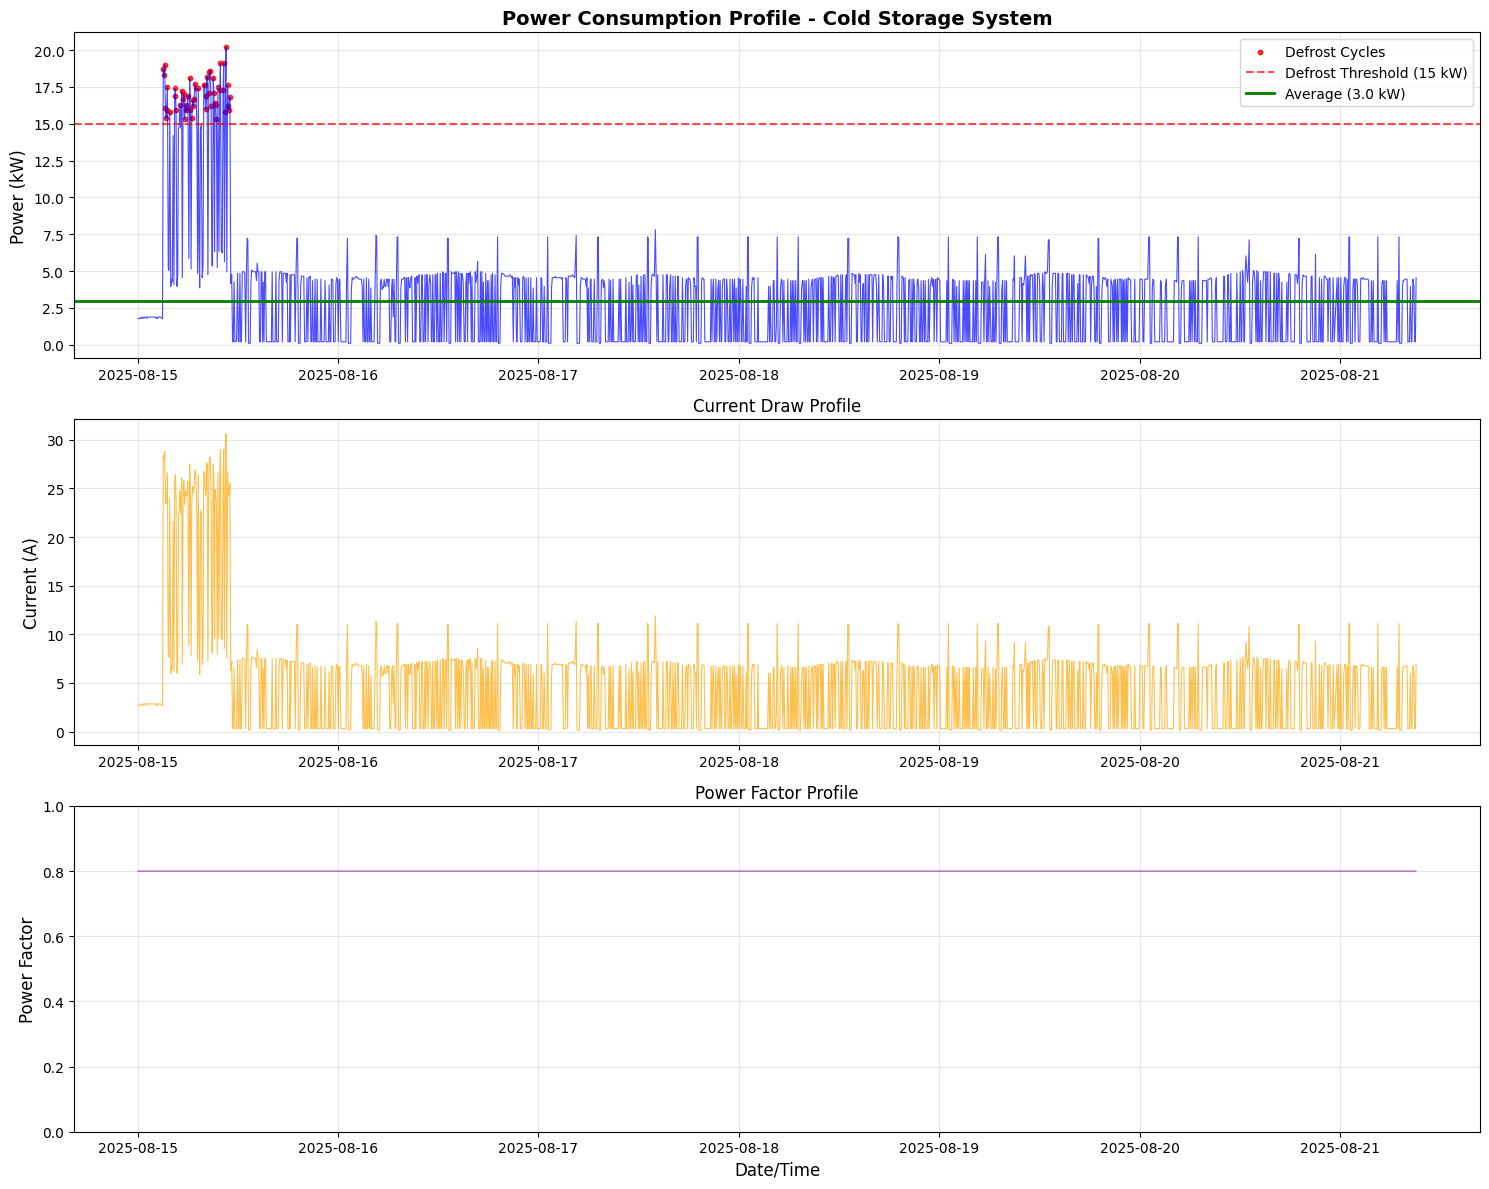

Creating power consumption analysis...


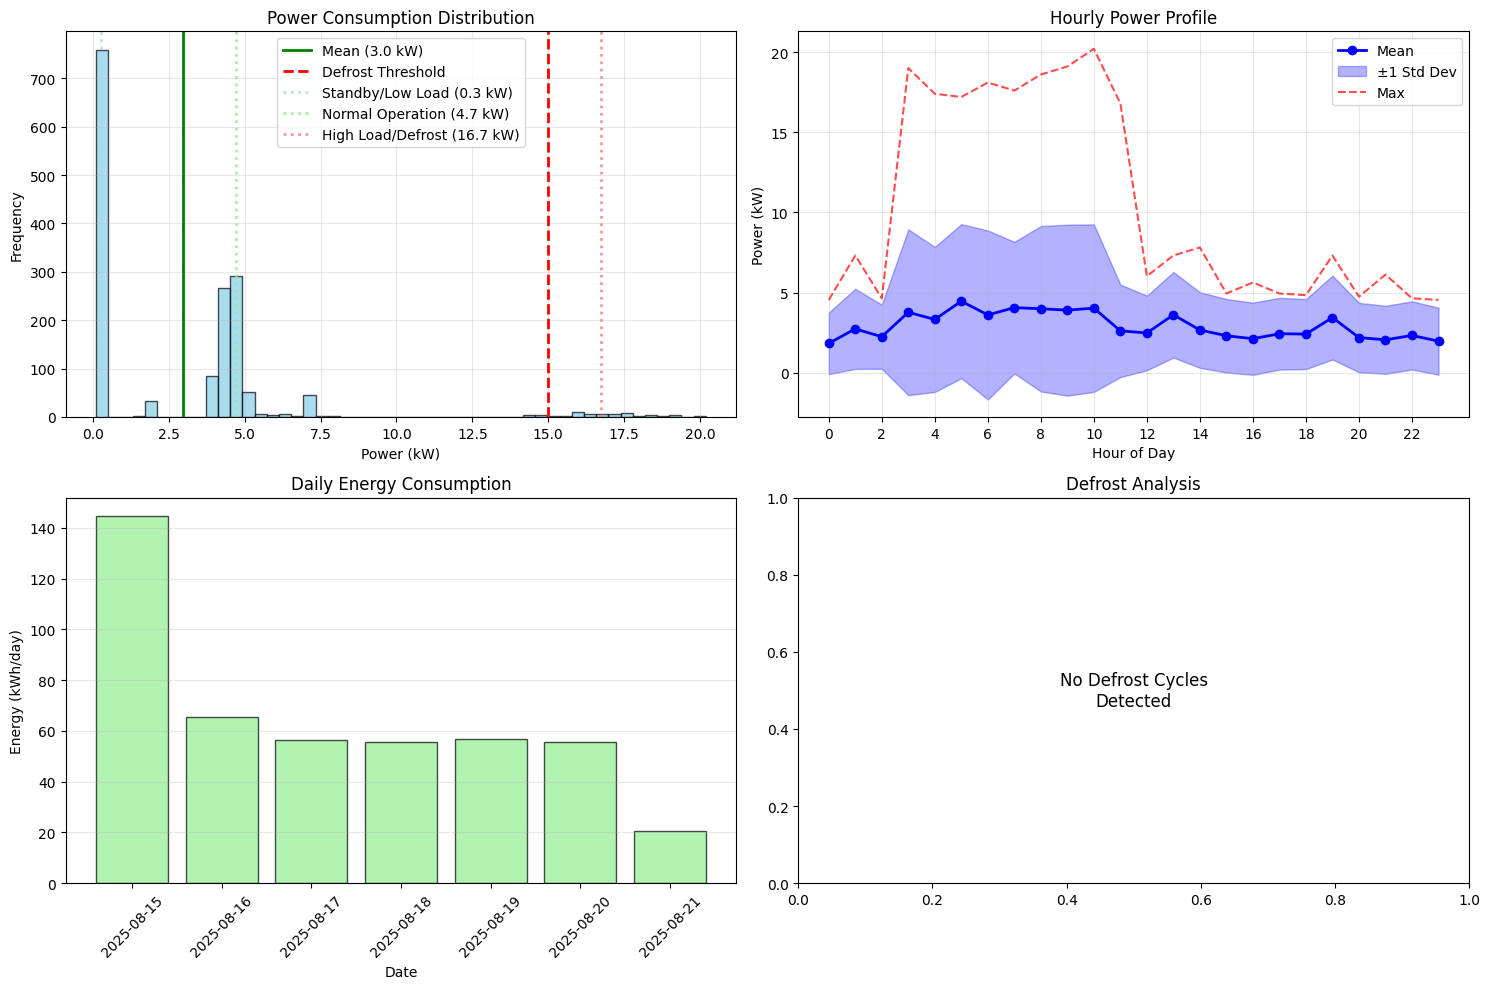

Creating defrost cycle analysis...


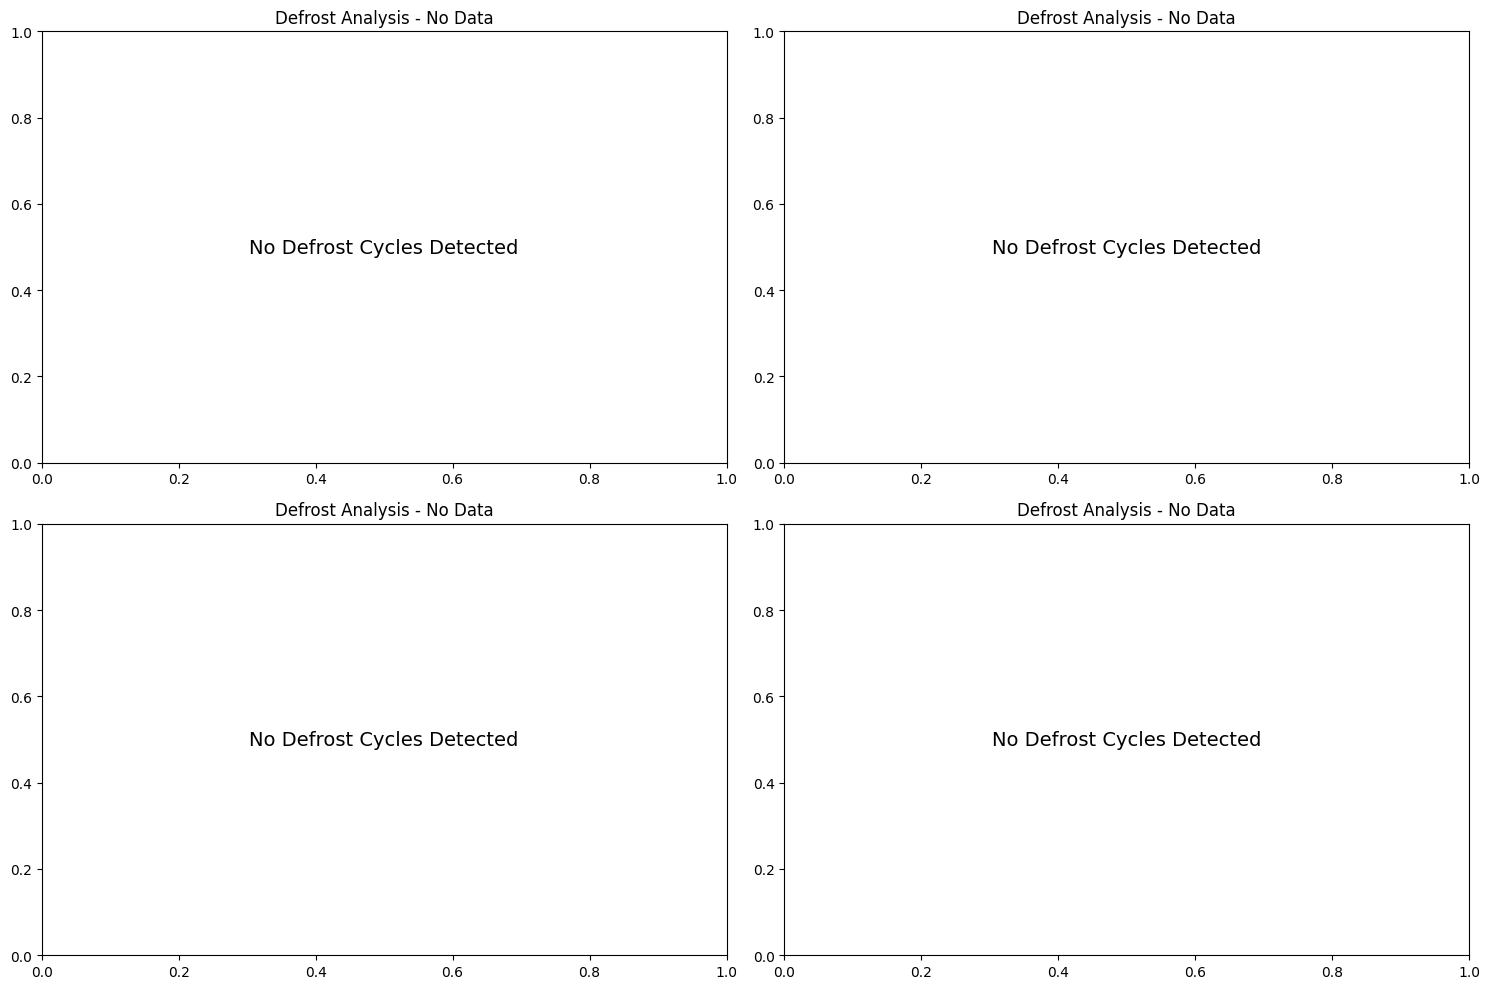

In [8]:
## 5. GENERATE ALL VISUALIZATIONS

print("\n" + "="*60)
print("GENERATING POWER ANALYSIS VISUALIZATIONS")
print("="*60)

if df is not None:
    # Full power profile
    print("Creating complete power consumption profile...")
    fig1 = plot_power_profile(df_with_defrost, include_defrost=True)
    plt.show()
    
    # Power consumption analysis
    print("Creating power consumption analysis...")
    fig2 = plot_power_analysis(df, defrost_df)
    plt.show()
    
    # Defrost cycle analysis
    print("Creating defrost cycle analysis...")
    fig3 = plot_defrost_analysis(defrost_df, df)
    plt.show()



DATE RANGE ANALYSIS EXAMPLE
Comparing first 2 days vs last 2 days...
First 2 days: 2025-08-15 to 2025-08-17
Last 2 days: 2025-08-19 to 2025-08-21


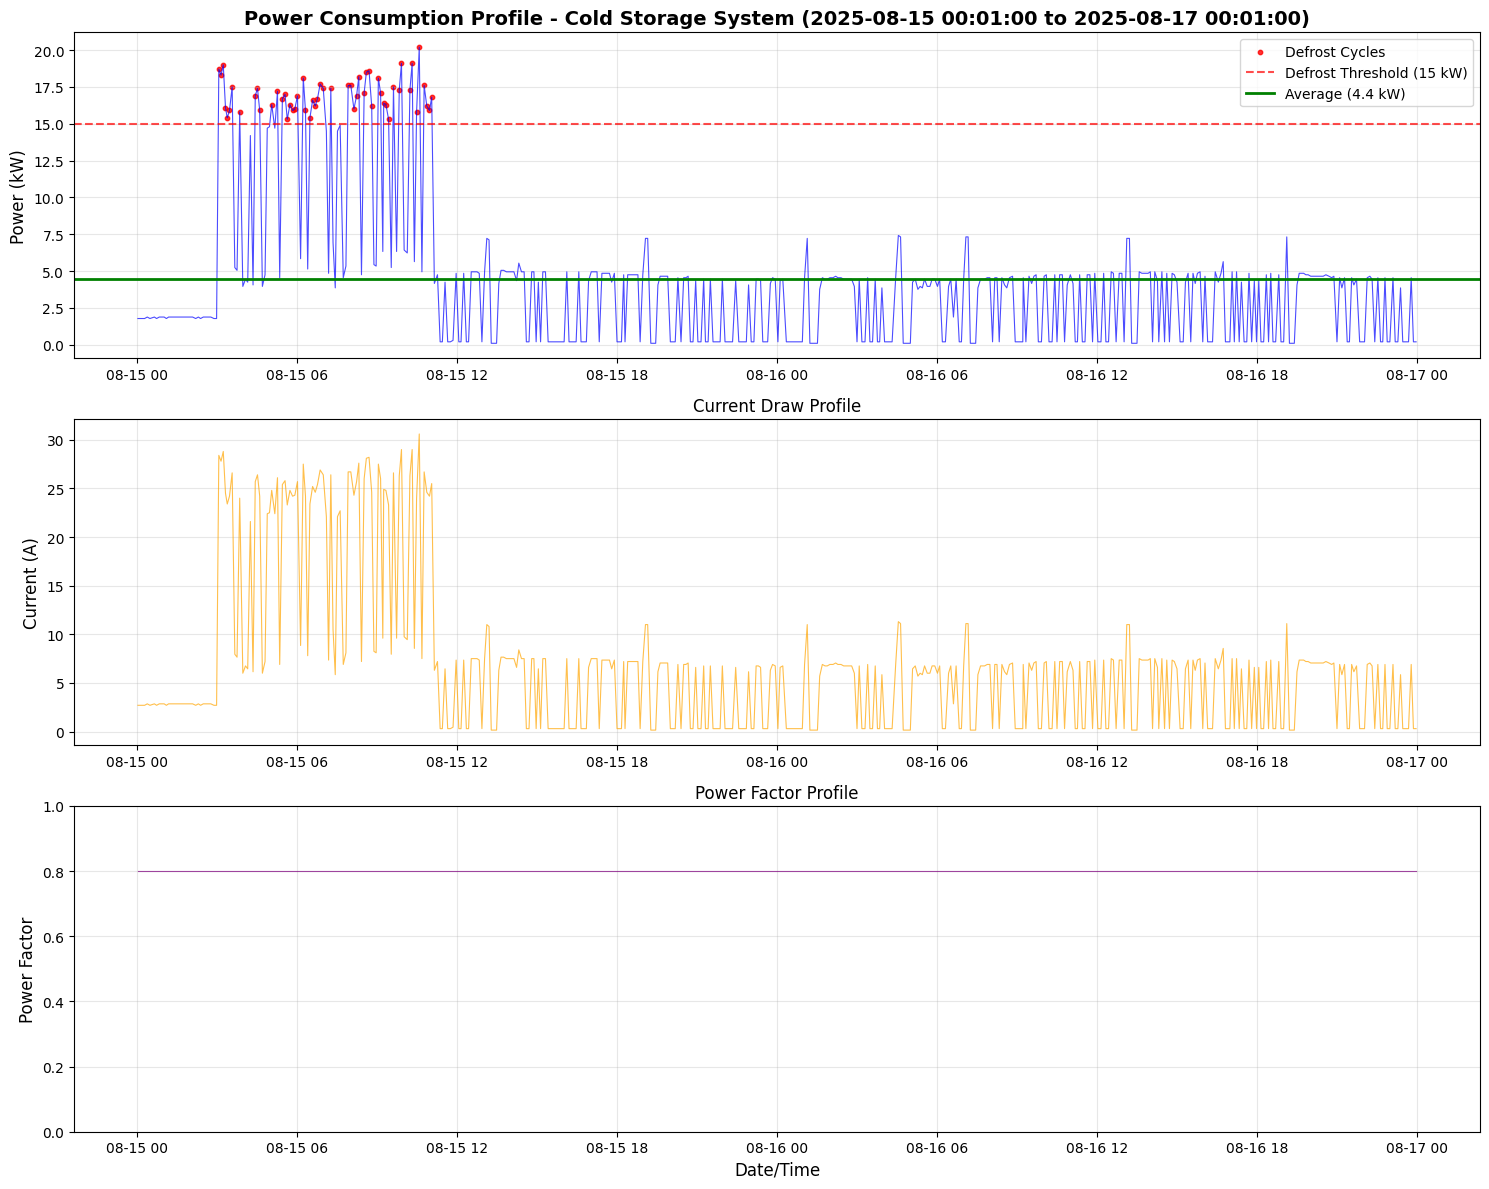

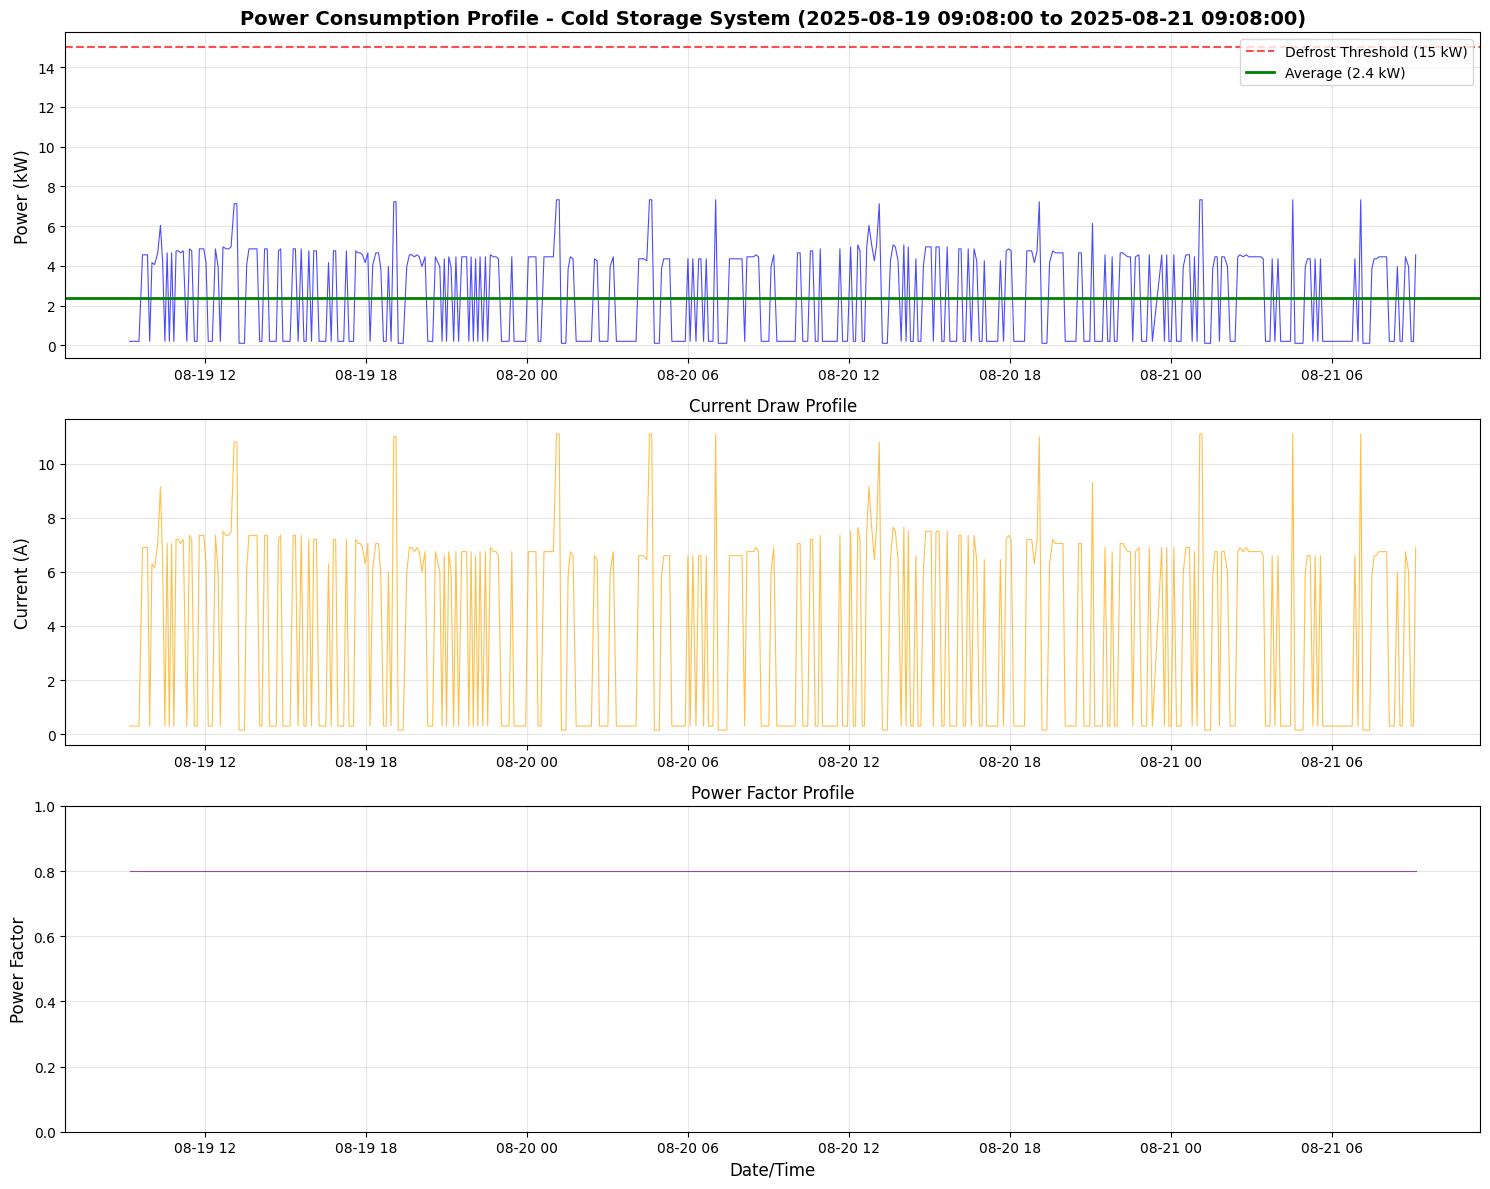

In [9]:
## 6. DATE RANGE ANALYSIS EXAMPLE

print("\n" + "="*60)
print("DATE RANGE ANALYSIS EXAMPLE")
print("="*60)

if df is not None:
    # Get first and last 2 days for comparison
    first_2days_end = df['time'].min() + timedelta(days=2)
    last_2days_start = df['time'].max() - timedelta(days=2)
    
    print("Comparing first 2 days vs last 2 days...")
    print(f"First 2 days: {df['time'].min().strftime('%Y-%m-%d')} to {first_2days_end.strftime('%Y-%m-%d')}")
    print(f"Last 2 days: {last_2days_start.strftime('%Y-%m-%d')} to {df['time'].max().strftime('%Y-%m-%d')}")
    
    # Plot first 2 days
    fig4 = plot_power_profile(df_with_defrost, 
                             start_date=df['time'].min(), 
                             end_date=first_2days_end,
                             include_defrost=True)
    plt.show()
    
    # Plot last 2 days
    fig5 = plot_power_profile(df_with_defrost, 
                             start_date=last_2days_start, 
                             end_date=df['time'].max(),
                             include_defrost=True)
    plt.show()


In [13]:
## 7. ADDITIONAL ANALYSIS AND RECOMMENDATIONS

print("\n" + "="*70)
print("ADDITIONAL ANALYSIS RECOMMENDATIONS")
print("="*70)

print("1. ENERGY EFFICIENCY OPTIMIZATION:")
print("   - Monitor load factor trends over time")
print("   - Compare power consumption with ambient temperature data")
print("   - Analyze correlation between defrost frequency and cooling load")

print("\n2. PREDICTIVE MAINTENANCE:")
print("   - Track power factor degradation as motor health indicator")
print("   - Monitor current draw increases indicating compressor wear")
print("   - Establish baseline power consumption for anomaly detection")

print("\n3. DEFROST OPTIMIZATION:")
print("   - Evaluate defrost scheduling efficiency")
print("   - Consider demand-based defrost vs. time-based")
print("   - Analyze post-defrost recovery time and power consumption")

print("\n4. DEMAND MANAGEMENT:")
print("   - Identify peak demand periods for load shedding opportunities")
print("   - Evaluate staggered defrost scheduling to reduce peak demand")
print("   - Consider thermal energy storage during off-peak periods")

print("\n5. COST ANALYSIS:")
print("   - Calculate energy costs based on time-of-use rates")
print("   - Evaluate demand charges from peak power consumption")
print("   - Assess potential savings from defrost schedule optimization")



ADDITIONAL ANALYSIS RECOMMENDATIONS
1. ENERGY EFFICIENCY OPTIMIZATION:
   - Monitor load factor trends over time
   - Compare power consumption with ambient temperature data
   - Analyze correlation between defrost frequency and cooling load

2. PREDICTIVE MAINTENANCE:
   - Track power factor degradation as motor health indicator
   - Monitor current draw increases indicating compressor wear
   - Establish baseline power consumption for anomaly detection

3. DEFROST OPTIMIZATION:
   - Evaluate defrost scheduling efficiency
   - Consider demand-based defrost vs. time-based
   - Analyze post-defrost recovery time and power consumption

4. DEMAND MANAGEMENT:
   - Identify peak demand periods for load shedding opportunities
   - Evaluate staggered defrost scheduling to reduce peak demand
   - Consider thermal energy storage during off-peak periods

5. COST ANALYSIS:
   - Calculate energy costs based on time-of-use rates
   - Evaluate demand charges from peak power consumption
   - Assess 

In [10]:
## 8. OPERATIONAL INSIGHTS SUMMARY

if df is not None:
    print("\n" + "="*70)
    print("OPERATIONAL INSIGHTS SUMMARY")
    print("="*70)
    
    # System efficiency assessment
    if metrics['load_factor'] > 0.7:
        efficiency_grade = "EXCELLENT"
        efficiency_color = "🟢"
    elif metrics['load_factor'] > 0.5:
        efficiency_grade = "GOOD"
        efficiency_color = "🟡"
    elif metrics['load_factor'] > 0.3:
        efficiency_grade = "FAIR"
        efficiency_color = "🟠"
    else:
        efficiency_grade = "POOR"
        efficiency_color = "🔴"
    
    print(f"{efficiency_color} SYSTEM EFFICIENCY: {efficiency_grade}")
    print(f"   Load Factor: {metrics['load_factor']:.2f}")
    print(f"   Average Power: {metrics['mean_power_kw']:.1f} kW")
    print(f"   Peak Demand: {metrics['max_power_kw']:.1f} kW")
    
    # Defrost system assessment
    if not defrost_df.empty:
        if defrost_metrics['cycles_per_day'] < 4:
            defrost_grade = "EFFICIENT"
            defrost_color = "🟢"
        elif defrost_metrics['cycles_per_day'] < 6:
            defrost_grade = "NORMAL"
            defrost_color = "🟡"
        else:
            defrost_grade = "FREQUENT"
            defrost_color = "🟠"
        
        print(f"{defrost_color} DEFROST OPERATION: {defrost_grade}")
        print(f"   Cycles per Day: {defrost_metrics['cycles_per_day']:.1f}")
        print(f"   Average Duration: {defrost_metrics['avg_cycle_duration']:.1f} minutes")
        print(f"   Defrost Energy: {defrost_metrics['total_defrost_energy']:.1f} kWh")
    
    print(f"\n📊 KEY PERFORMANCE INDICATORS:")
    print(f"   • Daily Energy Consumption: {metrics['average_hourly_consumption']*24:.1f} kWh/day")
    print(f"   • Power Factor: {metrics['average_power_factor']:.2f}")
    print(f"   • Current Utilization: {(metrics['average_current']/metrics['max_current'])*100:.1f}%")
    print(f"   • System Availability: {(len(df)/2500)*100:.1f}%")  # Assuming 5-min intervals expected
    
    print(f"\n⚡ ELECTRICAL HEALTH:")
    print(f"   • Operating Voltage: {metrics['average_voltage']:.0f} V")
    print(f"   • Power Factor: {metrics['average_power_factor']:.2f} (Target: >0.85)")
    print(f"   • Peak Current: {metrics['max_current']:.1f} A")
    
    print(f"\n🎯 OPTIMIZATION OPPORTUNITIES:")
    if metrics['load_factor'] < 0.5:
        print(f"   • Low load factor ({metrics['load_factor']:.2f}) suggests oversized equipment or poor utilization")
    if not defrost_df.empty and defrost_metrics['cycles_per_day'] > 6:
        print(f"   • High defrost frequency ({defrost_metrics['cycles_per_day']:.1f}/day) may indicate excessive frost buildup")
    if metrics['average_power_factor'] < 0.85:
        print(f"   • Poor power factor ({metrics['average_power_factor']:.2f}) may result in utility penalties")
    
    print(f"\n" + "="*70)
    print("Power meter analysis completed successfully!")
    print("="*70)


OPERATIONAL INSIGHTS SUMMARY
🔴 SYSTEM EFFICIENCY: POOR
   Load Factor: 0.15
   Average Power: 3.0 kW
   Peak Demand: 20.2 kW

📊 KEY PERFORMANCE INDICATORS:
   • Daily Energy Consumption: 71.3 kWh/day
   • Power Factor: 0.80
   • Current Utilization: 14.8%
   • System Availability: 64.6%

⚡ ELECTRICAL HEALTH:
   • Operating Voltage: 476 V
   • Power Factor: 0.80 (Target: >0.85)
   • Peak Current: 30.6 A

🎯 OPTIMIZATION OPPORTUNITIES:
   • Low load factor (0.15) suggests oversized equipment or poor utilization
   • Poor power factor (0.80) may result in utility penalties

Power meter analysis completed successfully!
